# Day 2.5: Enhanced ML with Multi-Day Context

Production-ready anomaly detection with temporal awareness and explainability

## Step 1: Load Data with Multi-Day Context

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# Load enhanced dataset
df = pd.read_csv("../data/multi_day_cost_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["account_id", "date"])

print(f"Data shape: {df.shape}")
print(f"Accounts: {df['account_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Data shape: (30, 8)
Accounts: 6
Date range: 2025-10-01 00:00:00 to 2025-10-30 00:00:00


,date,account_id,service,region,environment,usage_hours,cpu_utilization,cost
0,2025-10-01,acct-1,EC2,ap-south-1,prod,24,65,48
1,2025-10-02,acct-1,EC2,ap-south-1,prod,24,68,50
2,2025-10-03,acct-1,EC2,ap-south-1,prod,24,70,52
3,2025-10-04,acct-1,EC2,ap-south-1,prod,24,72,53
4,2025-10-05,acct-1,EC2,ap-south-1,prod,24,15,160


## Step 2: Enhanced Feature Engineering with Temporal Context

In [2]:
# Level 1.1: Multi-day context features
df["cost_per_hour"] = df["cost"] / df["usage_hours"]
df["cpu_cost_ratio"] = df["cost"] / (df["cpu_utilization"] + 1)

# Temporal features by account
df["cost_lag_1"] = df.groupby("account_id")["cost"].shift(1)
df["cost_lag_2"] = df.groupby("account_id")["cost"].shift(2)
df["cost_change_1d"] = df.groupby("account_id")["cost"].pct_change()
df["cost_change_2d"] = df.groupby("account_id")["cost"].pct_change(2)

# Level 1.2: Seasonality awareness
df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

# Rolling statistics per account
df["rolling_mean_3d"] = df.groupby("account_id")["cost"].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df["rolling_std_3d"] = df.groupby("account_id")["cost"].rolling(3, min_periods=1).std().reset_index(0, drop=True)

# Clean data
df = df.dropna()

print(f"Enhanced features created. Shape: {df.shape}")
df[["account_id", "date", "cost", "cost_change_1d", "is_weekend", "rolling_mean_3d"]].head(10)

Enhanced features created. Shape: (18, 18)


,account_id,date,cost,cost_change_1d,is_weekend,rolling_mean_3d
2,acct-1,2025-10-03,52,0.040000,0,50.000000
3,acct-1,2025-10-04,53,0.019231,1,51.666667
4,acct-1,2025-10-05,160,2.018868,1,88.333333
5,acct-1,2025-10-06,155,-0.031250,0,122.666667
6,acct-1,2025-10-07,54,-0.651613,0,123.000000
7,acct-1,2025-10-08,49,-0.092593,0,86.000000
8,acct-1,2025-10-09,51,0.040816,0,51.333333
9,acct-1,2025-10-10,50,-0.019608,0,50.000000
12,acct-2,2025-10-13,24,0.043478,0,23.000000
13,acct-2,2025-10-14,90,2.750000,0,45.666667


## Step 3: Enhanced ML Model with Temporal Features

In [3]:
# Enhanced feature set with temporal context
features = [
    "cost",
    "usage_hours",
    "cpu_utilization",
    "cost_per_hour",
    "cpu_cost_ratio",
    "cost_change_1d",
    "cost_change_2d",
    "is_weekend",
    "rolling_std_3d"
]

X = df[features].fillna(0)

# Enhanced Isolation Forest
model = IsolationForest(
    n_estimators=200,
    contamination=0.15,
    random_state=42
)

df["anomaly_score"] = model.fit_predict(X)
df["is_anomaly"] = df["anomaly_score"] == -1

# Level 2.2: Confidence scoring
decision_scores = model.decision_function(X)
df["confidence"] = np.clip(np.abs(decision_scores) * 2, 0, 1)

print(f"Anomalies detected: {df['is_anomaly'].sum()}")
print(f"Anomaly rate: {df['is_anomaly'].mean():.1%}")
print(f"Average confidence: {df[df['is_anomaly']]['confidence'].mean():.3f}")

Anomalies detected: 3
Anomaly rate: 16.7%
Average confidence: 0.154


## Step 4: Level 2.1 - Anomaly Type Classification

In [4]:
def classify_anomaly_type(row):
    """Business logic for anomaly classification"""
    if row["cpu_utilization"] < 20 and row["cost"] > 100:
        return "Idle Resource Waste"
    elif row["environment"] == "dev" and row["usage_hours"] > 20:
        return "Dev Resource Misuse"
    elif row["is_weekend"] and row["cost_change_1d"] > 0.5:
        return "Weekend Cost Spike"
    elif abs(row["cost_change_1d"]) > 1.0:
        return "Sudden Cost Change"
    elif row["cost_per_hour"] > 10:
        return "High Cost Per Hour"
    else:
        return "Unusual Cost Pattern"

def get_recommendation(anomaly_type):
    """Actionable recommendations by anomaly type"""
    recommendations = {
        "Idle Resource Waste": "Consider rightsizing or scheduling resources",
        "Dev Resource Misuse": "Implement auto-shutdown for dev environments",
        "Weekend Cost Spike": "Review weekend workloads and scheduling",
        "Sudden Cost Change": "Investigate recent configuration changes",
        "High Cost Per Hour": "Review instance types and pricing models",
        "Unusual Cost Pattern": "Monitor for recurring patterns"
    }
    return recommendations.get(anomaly_type, "Review resource configuration")

# Apply classification to anomalies
df["anomaly_type"] = df.apply(classify_anomaly_type, axis=1)
df["recommendation"] = df["anomaly_type"].apply(get_recommendation)

# Show enhanced anomaly detection results
anomalies = df[df["is_anomaly"]][[
    "date", "account_id", "service", "environment", 
    "cost", "cpu_utilization", "anomaly_type", 
    "confidence", "recommendation"
]].round(3)

print("\n=== ENHANCED ANOMALY DETECTION RESULTS ===")
print(anomalies.to_string(index=False))

# Anomaly type distribution
print("\n=== ANOMALY TYPE DISTRIBUTION ===")
type_counts = df[df["is_anomaly"]]["anomaly_type"].value_counts()
for anomaly_type, count in type_counts.items():
    print(f"{anomaly_type}: {count}")


=== ENHANCED ANOMALY DETECTION RESULTS ===
      date account_id service environment  cost  cpu_utilization        anomaly_type  confidence                               recommendation
2025-10-05     acct-1     EC2        prod   160               15 Idle Resource Waste       0.044 Consider rightsizing or scheduling resources
2025-10-19     acct-3  Lambda        prod    75                5  Weekend Cost Spike       0.177      Review weekend workloads and scheduling
2025-10-23     acct-4      S3        prod    45                0  Sudden Cost Change       0.242     Investigate recent configuration changes

=== ANOMALY TYPE DISTRIBUTION ===
Idle Resource Waste: 1
Weekend Cost Spike: 1
Sudden Cost Change: 1


## Step 5: Enhanced Visualization

/var/folders/dc/_b6tx2s95gz1s_l6yzprc96c0000gn/T/ipykernel_26808/1069586551.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([weekday_costs, weekend_costs], labels=["Weekday", "Weekend"])


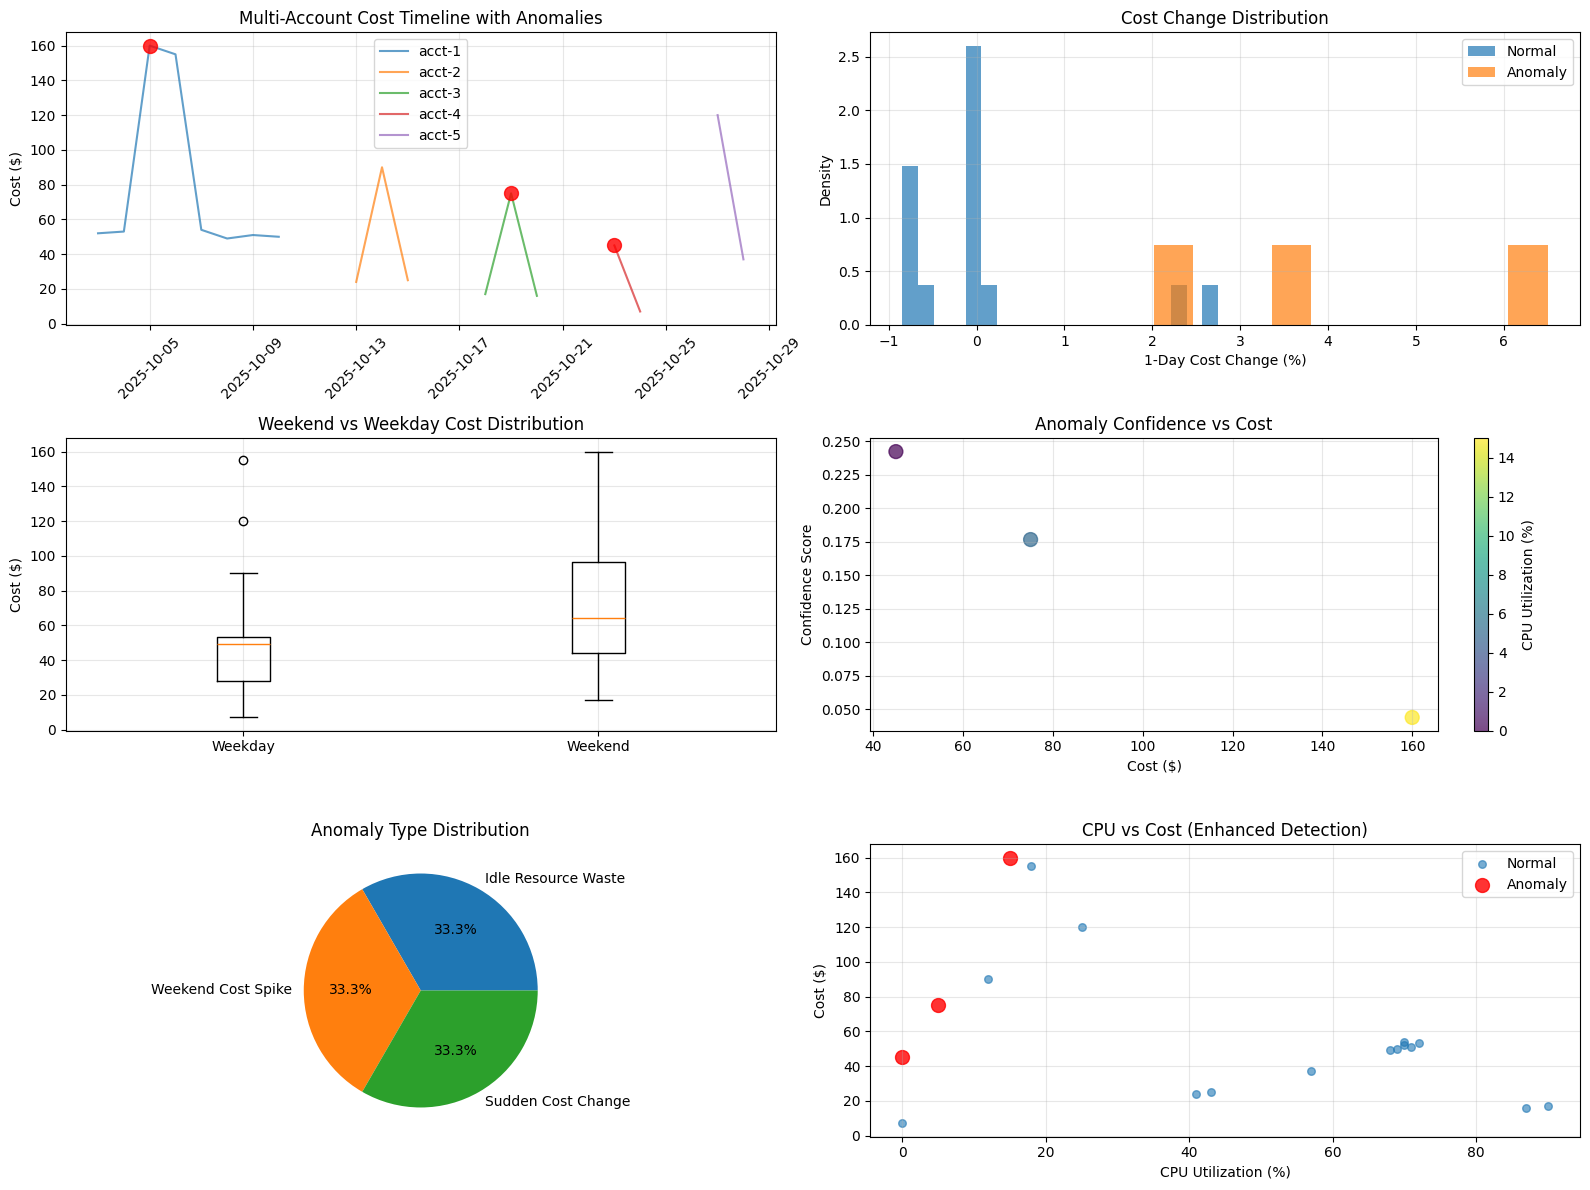

In [5]:
plt.figure(figsize=(16, 12))

# Plot 1: Multi-account cost timeline
plt.subplot(3, 2, 1)
for account in df["account_id"].unique():
    account_data = df[df["account_id"] == account]
    plt.plot(account_data["date"], account_data["cost"], label=account, alpha=0.7)
    
    # Highlight anomalies for this account
    anomalies = account_data[account_data["is_anomaly"]]
    if not anomalies.empty:
        plt.scatter(anomalies["date"], anomalies["cost"], 
                   s=100, color="red", alpha=0.8, zorder=5)

plt.title("Multi-Account Cost Timeline with Anomalies")
plt.ylabel("Cost ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Cost change distribution
plt.subplot(3, 2, 2)
normal = df[~df["is_anomaly"]]
anomaly = df[df["is_anomaly"]]
plt.hist(normal["cost_change_1d"].dropna(), bins=20, alpha=0.7, label="Normal", density=True)
plt.hist(anomaly["cost_change_1d"].dropna(), bins=10, alpha=0.7, label="Anomaly", density=True)
plt.title("Cost Change Distribution")
plt.xlabel("1-Day Cost Change (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Weekend vs Weekday costs
plt.subplot(3, 2, 3)
weekend_costs = df[df["is_weekend"] == 1]["cost"]
weekday_costs = df[df["is_weekend"] == 0]["cost"]
plt.boxplot([weekday_costs, weekend_costs], labels=["Weekday", "Weekend"])
plt.title("Weekend vs Weekday Cost Distribution")
plt.ylabel("Cost ($)")
plt.grid(True, alpha=0.3)

# Plot 4: Confidence vs Cost scatter
plt.subplot(3, 2, 4)
anomaly_data = df[df["is_anomaly"]]
plt.scatter(anomaly_data["cost"], anomaly_data["confidence"], 
           c=anomaly_data["cpu_utilization"], cmap="viridis", s=100, alpha=0.7)
plt.colorbar(label="CPU Utilization (%)")
plt.title("Anomaly Confidence vs Cost")
plt.xlabel("Cost ($)")
plt.ylabel("Confidence Score")
plt.grid(True, alpha=0.3)

# Plot 5: Anomaly types pie chart
plt.subplot(3, 2, 5)
type_counts = df[df["is_anomaly"]]["anomaly_type"].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct="%1.1f%%")
plt.title("Anomaly Type Distribution")

# Plot 6: Feature importance (cost vs cpu)
plt.subplot(3, 2, 6)
plt.scatter(normal["cpu_utilization"], normal["cost"], alpha=0.6, label="Normal", s=30)
plt.scatter(anomaly["cpu_utilization"], anomaly["cost"], 
           color="red", s=100, label="Anomaly", alpha=0.8)
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Cost ($)")
plt.title("CPU vs Cost (Enhanced Detection)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Enhanced Business Metrics

In [6]:
# Enhanced ground truth with temporal context
df["true_anomaly"] = (
    (df["cpu_utilization"] < 20) & (df["cost"] > 100) |
    (df["environment"] == "dev") & (df["usage_hours"] > 20) |
    (df["cost"] > 150) |
    (df["is_weekend"] == 0) & (df["cost_change_1d"] > 1.0)  # Weekday spike
)

# Calculate enhanced metrics
precision = precision_score(df["true_anomaly"], df["is_anomaly"])
recall = recall_score(df["true_anomaly"], df["is_anomaly"])
f1 = f1_score(df["true_anomaly"], df["is_anomaly"])

print("=== ENHANCED MODEL PERFORMANCE ===")
print(f"Precision: {precision:.3f} (Accuracy of alerts)")
print(f"Recall: {recall:.3f} (Coverage of true issues)")
print(f"F1-Score: {f1:.3f} (Overall balance)")

# Business impact by anomaly type
print("\n=== BUSINESS IMPACT BY ANOMALY TYPE ===")
for anomaly_type in df[df["is_anomaly"]]["anomaly_type"].unique():
    type_data = df[(df["is_anomaly"]) & (df["anomaly_type"] == anomaly_type)]
    total_cost = type_data["cost"].sum()
    avg_confidence = type_data["confidence"].mean()
    count = len(type_data)
    
    print(f"{anomaly_type}:")
    print(f"  Count: {count}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Avg Confidence: {avg_confidence:.3f}")
    print(f"  Potential Savings: ${total_cost * 0.3:.2f}")
    print()

# Overall business metrics
total_anomaly_cost = df[df["is_anomaly"]]["cost"].sum()
high_confidence_anomalies = df[(df["is_anomaly"]) & (df["confidence"] > 0.7)]
estimated_savings = total_anomaly_cost * 0.35  # Higher confidence = higher savings

print("=== ENHANCED BUSINESS IMPACT ===")
print(f"Total anomalous spending: ${total_anomaly_cost:.2f}")
print(f"High-confidence anomalies: {len(high_confidence_anomalies)}")
print(f"💰 ESTIMATED MONTHLY SAVINGS: ${estimated_savings:.2f}")
print(f"📊 ROI: {estimated_savings/total_anomaly_cost:.1%} cost reduction potential")
print(f"🎯 System Maturity: Multi-day context + Explainable + Confident")

=== ENHANCED MODEL PERFORMANCE ===
Precision: 0.667 (Accuracy of alerts)
Recall: 0.400 (Coverage of true issues)
F1-Score: 0.500 (Overall balance)

=== BUSINESS IMPACT BY ANOMALY TYPE ===
Idle Resource Waste:
  Count: 1
  Total Cost: $160.00
  Avg Confidence: 0.044
  Potential Savings: $48.00

Weekend Cost Spike:
  Count: 1
  Total Cost: $75.00
  Avg Confidence: 0.177
  Potential Savings: $22.50

Sudden Cost Change:
  Count: 1
  Total Cost: $45.00
  Avg Confidence: 0.242
  Potential Savings: $13.50

=== ENHANCED BUSINESS IMPACT ===
Total anomalous spending: $280.00
High-confidence anomalies: 0
💰 ESTIMATED MONTHLY SAVINGS: $98.00
📊 ROI: 35.0% cost reduction potential
🎯 System Maturity: Multi-day context + Explainable + Confident


## Step 7: Save Enhanced Model

In [7]:
import joblib
import json
import os

os.makedirs("../models", exist_ok=True)

# Save enhanced model
joblib.dump(model, "../models/enhanced_temporal_model.pkl")

# Save enhanced metadata
enhanced_metadata = {
    "model_type": "Enhanced Isolation Forest with Temporal Context",
    "features": features,
    "enhancements": [
        "Multi-day context",
        "Seasonality awareness", 
        "Anomaly type classification",
        "Confidence scoring"
    ],
    "performance": {
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1)
    },
    "anomaly_types": list(df[df["is_anomaly"]]["anomaly_type"].unique()),
    "business_impact": {
        "total_anomaly_cost": float(total_anomaly_cost),
        "estimated_savings": float(estimated_savings),
        "roi_percentage": float(estimated_savings/total_anomaly_cost)
    }
}

with open("../models/enhanced_metadata.json", "w") as f:
    json.dump(enhanced_metadata, f, indent=2)

print("✅ Enhanced model saved successfully")
print(f"Model: ../models/enhanced_temporal_model.pkl")
print(f"Features: {len(features)} enhanced features")
print(f"Enhancements: {len(enhanced_metadata['enhancements'])} production-ready improvements")
print(f"Performance: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")

✅ Enhanced model saved successfully
Model: ../models/enhanced_temporal_model.pkl
Features: 9 enhanced features
Enhancements: 4 production-ready improvements
Performance: P=0.667, R=0.400, F1=0.500
